In [27]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [32]:
# Download and load the cifar10 data
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.cifar10.load_data()
)

In [33]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

In [34]:
train_images, train_labels = normalize_img(train_images, train_labels)
test_images, test_labels = normalize_img(test_images, test_labels)

In [43]:
def plot_history(history):

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  train_acc = history.history['acc']
  val_acc = history.history['val_acc']

  plt.figure(figsize=(10,10))

  plt.subplot(121)
  plt.plot(np.arange(1,len(train_loss)+1), train_loss)
  plt.plot(np.arange(1,len(train_loss)+1), val_loss)
  plt.legend(['train','validation'])
  plt.grid()
  plt.xlabel('epoch')
  plt.ylabel('loss')

  plt.subplot(122)
  plt.plot(np.arange(1,len(train_loss)+1), train_acc)
  plt.plot(np.arange(1,len(train_loss)+1), val_acc)
  plt.legend(['train','validation'])
  plt.grid()
  plt.xlabel('epoch')
  plt.ylabel('accuracy')

## ResNet Block


#### Without `dropout`


In [36]:
class ResBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters, dropout=0.0):
        super(ResBlock, self).__init__()

        self.cnn1 = tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=(3, 3),
            padding="same",
            activation="relu",
            kernel_initializer="he_uniform",
        )

        self.cnn2 = tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=(3, 3),
            padding="same",
            kernel_initializer="he_uniform",
        )  # No activation here

        self.activation = tf.keras.layers.ReLU()

    def call(self, inputs, training=False):
        x = self.cnn1(inputs)

        x = self.cnn2(x)

        # Residual connection
        x += inputs  # Skip connection

        out = self.activation(x) # Apply ReLU after addition
        
        return out

#### With `dropout`


In [37]:
class ResBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters, dropout=0.0):
        super(ResBlock, self).__init__()

        self.cnn1 = tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=(3, 3),
            padding="same",
            activation="relu",
            kernel_initializer="he_uniform",
        )
        self.dropout1 = tf.keras.layers.Dropout(dropout) if dropout > 0 else None

        self.cnn2 = tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=(3, 3),
            padding="same",
            kernel_initializer="he_uniform",
        )  # No activation here
        self.dropout2 = tf.keras.layers.Dropout(dropout) if dropout > 0 else None

        self.activation = tf.keras.layers.ReLU()

    def call(self, inputs, training=False):
        x = self.cnn1(inputs)
        if self.dropout1:
            x = self.dropout1(x, training=training)

        x = self.cnn2(x)
        if self.dropout2:
            x = self.dropout2(x, training=training)

        # Residual connection
        x += inputs  # Skip connection

        return self.activation(x)  # Apply ReLU after addition

In [38]:
class ResBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters, dropout_rate=0.0):
        super(ResBlock, self).__init__()

        self.cnn1 = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same', activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

        self.cnn2 = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

        # 1x1 Conv to match input channels if necessary
        self.shortcut = tf.keras.layers.Conv2D(num_filters, (1, 1), padding='same')

        self.activation = tf.keras.layers.ReLU()

    def call(self, inputs, training=False):
        shortcut = self.shortcut(inputs)  # Ensure input shape matches output shape

        x = self.cnn1(inputs)
        x = self.dropout1(x, training=training)  # Apply dropout during training

        x = self.cnn2(x)
        x = self.dropout2(x, training=training)  # Apply dropout during training

        x += shortcut  # Add residual connection
        return self.activation(x)


In [41]:
in_layer = tf.keras.layers.Input(shape=(32,32,3,))

# 3 Resnet blocks with dropout (30%)
b = ResBlock(32, 0.3)(in_layer)
b = ResBlock(64, 0.3)(b)
b = ResBlock(128, 0.3)(b)

b = tf.keras.layers.Flatten()(b)
b = tf.keras.layers.Dense(128, activation='relu')(b)
b = tf.keras.layers.Dropout(0.4)(b)
out_layer = tf.keras.layers.Dense(10, activation='softmax')(b)

model = tf.keras.Model(in_layer, out_layer)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block_12 (ResBlock)         │ (None, 32, 32, 32)     │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block_13 (ResBlock)         │ (None, 32, 32, 64)     │        57,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block_14 (ResBlock)         │ (None, 32, 32, 128)    │       229,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,076,202 (65.14 MB)

 Trainable params: 17,076,202 (65.14 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history = model.fit(train_images, train_labels,
                    epochs=50, validation_split=0.1, 
                    callbacks=tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 371s 263ms/step - acc: 0.2494 - loss: 2.0810 - val_acc: 0.1068 - val_loss: 2.3004
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 387s 275ms/step - acc: 0.4219 - loss: 1.5575 - val_acc: 0.1038 - val_loss: 2.3139
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 383s 272ms/step - acc: 0.4912 - loss: 1.3908 - val_acc: 0.1038 - val_loss: 2.3186
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 373s 265ms/step - acc: 0.5268 - loss: 1.3025 - val_acc: 0.1038 - val_loss: 2.3207
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 368s 262ms/step - acc: 0.5500 - loss: 1.2394 - val_acc: 0.1038 - val_loss: 2.3237
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 359s 255ms/step - acc: 0.5733 - loss: 1.1827 - val_acc: 0.1038 - val_loss: 2.3255


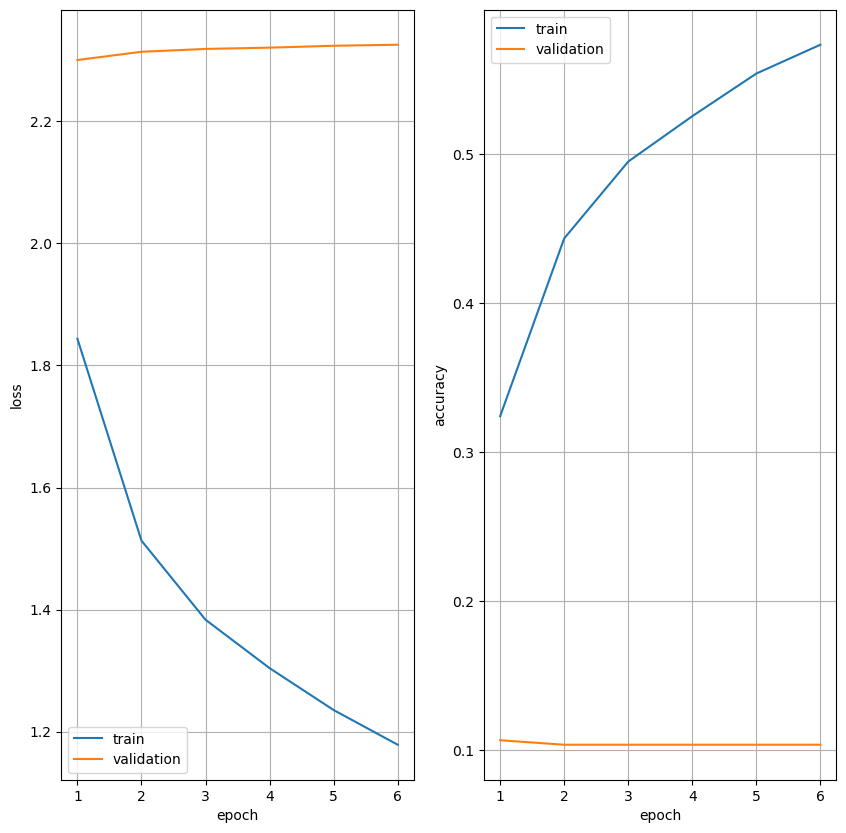

In [44]:
plot_history(history)